<a href="https://colab.research.google.com/github/adrinorosario/cifar100-hybrid-architectures/blob/main/cifar_100_hybrid_architectures_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install tqdm torchinfo

In [ ]:
from tqdm.auto import tqdm
from torchinfo import summary
import time

tqdm, summary

(tqdm.auto.tqdm,
 <function torchinfo.torchinfo.summary(model: 'nn.Module', input_size: 'INPUT_SIZE_TYPE | None' = None, input_data: 'INPUT_DATA_TYPE | None' = None, batch_dim: 'int | None' = None, cache_forward_pass: 'bool | None' = None, col_names: 'Iterable[str] | None' = None, col_width: 'int' = 25, depth: 'int' = 3, device: 'torch.device | str | None' = None, dtypes: 'list[torch.dtype] | None' = None, mode: 'str | None' = None, row_settings: 'Iterable[str] | None' = None, verbose: 'int | None' = None, **kwargs: 'Any') -> 'ModelStatistics'>)

In [ ]:
from torchvision.transforms import v2

cifar_policy = v2.AutoAugmentPolicy.CIFAR10

In [ ]:
data_transforms = transforms.Compose([
    # v2.AutoAugment(policy=cifar_policy),
    transforms.RandomCrop(32, padding=4),              # random crop with padding
    transforms.RandomHorizontalFlip(),                 # random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # color jittering
    transforms.ToTensor(),                             # convert to tensor
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),  # CIFAR-100 stats
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.268, 0.257, 0.277]),
])

# data_transforms_policy_augment = transforms.Compose([
#     v2.AutoAugment(policy=cifar_policy),
#     # transforms.RandomCrop(32, padding=4),              # random crop with padding
#     # transforms.RandomHorizontalFlip(),                 # random horizontal flip
#     # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # color jittering
#     transforms.ToTensor(),                             # convert to tensor
#     # transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),  # CIFAR-100 stats
# ])

In [ ]:
# cifar100_train_only_policy_augment = datasets.CIFAR100(root="data", train=True, download=True, transform=data_transforms_policy_augment, target_transform=None)
# cifar100_test_only_policy_augment = datasets.CIFAR100(root="data", train=False, download=True, transform=data_transforms_policy_augment, target_transform=None)

cifar100_train = datasets.CIFAR100(root="data", train=True, download=True, transform=data_transforms, target_transform=None)
cifar100_test = datasets.CIFAR100(root="data", train=False, download=True, transform=test_transform, target_transform=None)

# cifar100_train_ = datasets.CIFAR100(root="data", train=True, download=True, transform=transforms.ToTensor(), target_transform=None)
# cifar100_test_ = datasets.CIFAR100(root="data", train=False, download=True, transform=transforms.ToTensor(), target_transform=None)

# cifar100_train, cifar100_test

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(cifar100_train.classes)

100

In [ ]:
image, label = cifar100_train[0]
image.shape, label

(torch.Size([3, 32, 32]), 19)

/tmp/ipykernel_31/22530547.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  plt.imshow(image.T)


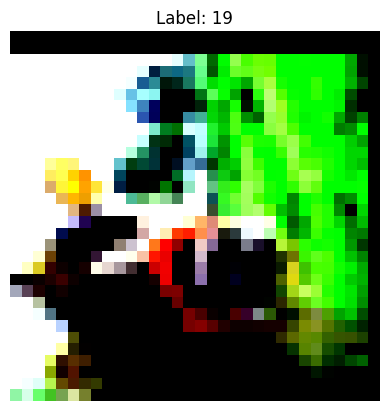

In [ ]:
plt.imshow(image.T)
plt.title(f"Label: {label}")
plt.axis(False)
plt.show()

In [ ]:
# train100_policy_dataloader = DataLoader(cifar100_train_only_policy_augment, batch_size=32, shuffle=True)
# test100_policy_dataloader = DataLoader(cifar100_test_only_policy_augment, batch_size=32, shuffle=False)

train100_dataloader = DataLoader(cifar100_train, batch_size=32, shuffle=True)
test100_dataloader = DataLoader(cifar100_test, batch_size=32, shuffle=False)

# train100_dataloader_ = DataLoader(cifar100_train_, batch_size=32, shuffle=True)
# test100_dataloader_ = DataLoader(cifar100_test_, batch_size=32, shuffle=False)

# train100_dataloader, test100_dataloader, train100_policy_dataloader, test100_policy_dataloader

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
from typing import Tuple

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
def model_train(model: nn.Module,
                loss_fn: nn.Module,
                optimizer_fn: torch.optim,
                dataloader: torch.utils.data.DataLoader,
                device: str,
                epochs: int,
                accuracy_fn=accuracy_fn) -> Tuple[torch.Tensor, float]:
  model.to(device)
  model.train()
  steps_per_epoch = len(dataloader)
  train_loss, train_acc = 0, 0

  scheduler = OneCycleLR(
    optimizer_fn,
    max_lr=0.1,  # Peak learning rate
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.3,  # Percentage of cycle for increasing LR
    anneal_strategy='cos',  # Cosine annealing
    cycle_momentum=True,
    base_momentum=0.85,
    max_momentum=0.95,
    div_factor=25.0,  # Determines initial LR via initial_lr = max_lr/div_factor
    final_div_factor=1e4  # Determines minimum LR via min_lr = initial_lr/final_div_factor
    )

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer_fn.zero_grad()
    loss.backward()
    optimizer_fn.step()
    scheduler.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train loss: {train_loss: .5f} | Train acc: {train_acc: .2f}%")

  return (train_loss, train_acc)

In [ ]:
def model_test(model: nn.Module,
               loss_fn: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               device: str,
               accuracy_fn=accuracy_fn) -> Tuple[torch.Tensor, float]:
  model.to(device)
  model.eval()

  with torch.inference_mode():
    test_loss, test_acc = 0, 0

    for X, y in dataloader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      loss = loss_fn(test_pred, y)

      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print(f"Test loss: {test_loss: .5f} | Test acc: {test_acc: .2f}%")

    return (test_loss, test_acc)

In [ ]:
def print_train_time(start: float, end: float, model: nn.Module, device: str):
  total_time = end - start
  print(f"Train time on {device}: {total_time}")
  return {
      "model": model._get_name(),
      "train_time": total_time,
      "device": device
  }

In [ ]:
class Cifar100v1(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU()
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU()
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.3),
        nn.Linear(in_features=512*8*8, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)

    x = self.classifier(x)
    return x

In [ ]:
512*8*8

32768

In [ ]:
model_0 = Cifar100v1(input_shape=3, output_shape=len(cifar100_train.classes))
model_0

Cifar100v1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [ ]:
summary(model=model_0, input_size=(32, 3 , 32, 32), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Cifar100v1 (Cifar100v1)                  [32, 3, 32, 32]      [32, 100]            --                   True
├─Sequential (conv_block1)               [32, 3, 32, 32]      [32, 128, 32, 32]    --                   True
│    └─Conv2d (0)                        [32, 3, 32, 32]      [32, 128, 32, 32]    3,584                True
│    └─BatchNorm2d (1)                   [32, 128, 32, 32]    [32, 128, 32, 32]    256                  True
│    └─ReLU (2)                          [32, 128, 32, 32]    [32, 128, 32, 32]    --                   --
│    └─Conv2d (3)                        [32, 128, 32, 32]    [32, 128, 32, 32]    147,584              True
│    └─BatchNorm2d (4)                   [32, 128, 32, 32]    [32, 128, 32, 32]    256                  True
│    └─ReLU (5)                          [32, 128, 32, 32]    [32, 128, 32, 32]    --                   --
├─Sequential (conv

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [ ]:
epochs = 70
train_losses, test_losses = [], []
train_accs, test_accs = [], []

start_train_time_model_0 = time.time()

steps_per_epoch = len(train100_dataloader)

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.1,  # Peak learning rate
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.3,  # Percentage of cycle for increasing LR
    anneal_strategy='cos',  # Cosine annealing
    cycle_momentum=True,
    base_momentum=0.85,
    max_momentum=0.95,
    div_factor=25.0,  # Determines initial LR via initial_lr = max_lr/div_factor
    final_div_factor=1e4  # Determines minimum LR via min_lr = initial_lr/final_div_factor
)

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n---")
  train_loss, train_acc = 0, 0

  model_0.to(device)
  model_0.train()

  for batch, (X, y) in enumerate(train100_dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

  train_loss /= len(train100_dataloader)
  train_acc /= len(train100_dataloader)

  train_losses.append(train_loss)
  train_accs.append(train_acc)

  print(f"Train loss: {train_loss: .5f} | Train acc: {train_acc: .2f}%")

  model_0.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0

    for X, y in test100_dataloader:

      X, y = X.to(device), y.to(device)

      test_pred = model_0(X)

      loss = loss_fn(test_pred, y)

      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test100_dataloader)
    test_acc /= len(test100_dataloader)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Test loss: {test_loss: .5f} | Test acc: {test_acc: .2f}%")

stop_train_time_model_0 = time.time()

train_time_model_0 = print_train_time(start=start_train_time_model_0,
                                      end=stop_train_time_model_0,
                                      model=model_0,
                                      device=device)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 0
---
Train loss:  4.88952 | Train acc:  5.15%
Test loss:  4.04442 | Test acc:  10.20%
Epoch: 1
---
Train loss:  4.06411 | Train acc:  9.96%
Test loss:  3.80906 | Test acc:  15.22%
Epoch: 2
---
Train loss:  3.85515 | Train acc:  14.39%
Test loss:  3.48494 | Test acc:  22.39%
Epoch: 3
---
Train loss:  3.62178 | Train acc:  19.36%
Test loss:  3.28132 | Test acc:  27.43%
Epoch: 4
---
Train loss:  3.39526 | Train acc:  24.70%
Test loss:  3.09741 | Test acc:  32.53%
Epoch: 5
---
Train loss:  3.16863 | Train acc:  30.28%
Test loss:  2.91471 | Test acc:  37.51%
Epoch: 6
---
Train loss:  3.01314 | Train acc:  34.23%
Test loss:  2.88976 | Test acc:  39.23%
Epoch: 7
---
Train loss:  2.94012 | Train acc:  36.46%
Test loss:  2.97608 | Test acc:  37.13%
Epoch: 8
---
Train loss:  2.90388 | Train acc:  37.06%
Test loss:  2.85063 | Test acc:  39.36%
Epoch: 9
---
Train loss:  2.90795 | Train acc:  37.12%
Test loss:  2.80059 | Test acc:  41.32%
Epoch: 10
---
Train loss:  2.95438 | Train acc:  35.

KeyboardInterrupt: 

In [ ]:
train_time_model_0

In [ ]:
torch.save(model_0.state_dict(), '/kaggle/working/my_model.pth')

In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [ ]:
train_losses = [x.cpu() for x in train_losses]
test_losses = [x.cpu() for x in test_losses]

In [ ]:
train_losses = [x.detach().numpy() for x in train_losses]
test_losses = [x.detach().numpy() for x in test_losses]

In [ ]:
plt.plot(np.arange(1, epochs+1), train_losses, label="Train loss")
plt.plot(np.arange(1, epochs+1), test_losses, label="Test loss")
plt.legend(loc="best")
plt.show()

In [ ]:
plt.plot(np.arange(1, epochs+1), train_accs, label="Train accuracy")
plt.plot(np.arange(1, epochs+1), test_accs, label="Test accuracy")
plt.legend(loc="best")
plt.show()

In [ ]:
def plot_curves(epochs: int, metric: str,  metric_arr1: list, metric_arr2: list, to_cpu=True):

  if to_cpu:
    metric_arr1 = [x.cpu() for x in metric_arr1]
    metric_arr2 = [x.cpu() for x in metric_arr2]
    metric_arr1 = [x.detach().numpy() for x in metric_arr1]
    metric_arr2 = [x.detach().numpy() for x in metric_arr2]

  plt.plot(np.arange(1, epochs+1), metric_arr1, label=f"Train {metric}")
  plt.plot(np.arange(1, epochs+1), metric_arr2, label=f"Test {metric}")
  plt.legend(loc="best")
  plt.show()

In [ ]:
class FireModule(nn.Module):
  def __init__(self, input_shape: int, squeeze_channels: int, expand1x1_channels: int, expand3x3_channels: int):
    super().__init__()

    self.squeeze = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=squeeze_channels, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(num_features=squeeze_channels),
        nn.ReLU()
    )

    self.expand1x1 = nn.Sequential(
        nn.Conv2d(in_channels=squeeze_channels, out_channels=expand1x1_channels, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(num_features=expand1x1_channels),
        nn.ReLU()
    )

    self.expand3x3 = nn.Sequential(
        nn.Conv2d(in_channels=squeeze_channels, out_channels=expand3x3_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=expand3x3_channels),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.squeeze(x)

    ex1 = self.expand1x1(x)
    ex2 = self.expand3x3(x)

    out = torch.cat([ex1, ex2], dim=1)
    return out

In [ ]:
512*16

8192

In [ ]:
class Cifar100v2(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super(Cifar100v2, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fire2 = FireModule(96, 16, 32, 32)

    self.fire3 = FireModule(64, 16, 32, 32)

    self.fire4 = nn.Sequential(
        FireModule(64, 16, 64, 64),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fire5 = FireModule(128, 16, 128, 128)

    self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.adp_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.3),
        nn.Linear(in_features=512, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)

    x = self.fire2(x)

    x = self.fire3(x)

    x = self.fire4(x)

    x = self.fire5(x)

    x = self.conv6(x)

    x = self.adp_avg_pool(x)

    x = self.classifier(x)
    return x

In [ ]:
model_1 = Cifar100v2(input_shape=3, output_shape=len(cifar100_train.classes))
model_1

Cifar100v2(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fire2): FireModule(
    (squeeze): Sequential(
      (0): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (expand1x1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (expand3x3): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (fire3): FireModule(
    (squeeze): Sequ

In [ ]:
summary(model=model_1, input_size=(32, 3 , 32, 32), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Cifar100v2 (Cifar100v2)                  [32, 3, 32, 32]      [32, 100]            --                   True
├─Sequential (conv1)                     [32, 3, 32, 32]      [32, 96, 16, 16]     --                   True
│    └─Conv2d (0)                        [32, 3, 32, 32]      [32, 96, 32, 32]     2,688                True
│    └─BatchNorm2d (1)                   [32, 96, 32, 32]     [32, 96, 32, 32]     192                  True
│    └─ReLU (2)                          [32, 96, 32, 32]     [32, 96, 32, 32]     --                   --
│    └─MaxPool2d (3)                     [32, 96, 32, 32]     [32, 96, 16, 16]     --                   --
├─FireModule (fire2)                     [32, 96, 16, 16]     [32, 64, 16, 16]     --                   True
│    └─Sequential (squeeze)              [32, 96, 16, 16]     [32, 16, 16, 16]     --                   True
│    │    └─Conv2d

In [ ]:
loss_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [ ]:
epochs = 50
train_losses, test_losses = [], []
train_accs, test_accs = [], []

start_train_time_model_1 = time.time()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---")

  train_loss, train_acc = model_train(model=model_1,
                                      loss_fn=loss_1,
                                      optimizer_fn=optimizer_1,
                                      dataloader=train100_dataloader,
                                      device=device,
                                      epochs=epochs,
                                      accuracy_fn=accuracy_fn)

  test_loss, test_acc = model_test(model=model_1,
                                   loss_fn=loss_1,
                                   dataloader=test100_dataloader,
                                   device=device,
                                   accuracy_fn=accuracy_fn)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

stop_train_time_model_1 = time.time()

train_time_model_1 = print_train_time(start=start_train_time_model_1,
                                      end=stop_train_time_model_1,
                                      model=model_1,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---
Train loss:  4.10718 | Train acc:  6.94%
Test loss:  3.68084 | Test acc:  11.44%
Epoch: 1
---
Train loss:  3.60217 | Train acc:  13.77%
Test loss:  3.24637 | Test acc:  19.55%
Epoch: 2
---
Train loss:  3.27699 | Train acc:  19.43%
Test loss:  3.09306 | Test acc:  22.03%
Epoch: 3
---
Train loss:  3.02647 | Train acc:  24.13%
Test loss:  2.84047 | Test acc:  27.95%
Epoch: 4
---
Train loss:  2.85369 | Train acc:  27.66%
Test loss:  2.71611 | Test acc:  30.17%
Epoch: 5
---
Train loss:  2.70558 | Train acc:  30.65%
Test loss:  2.52513 | Test acc:  34.40%
Epoch: 6
---
Train loss:  2.59376 | Train acc:  32.92%
Test loss:  2.42528 | Test acc:  37.05%
Epoch: 7
---
Train loss:  2.50594 | Train acc:  34.99%
Test loss:  2.45763 | Test acc:  36.34%
Epoch: 8
---
Train loss:  2.42587 | Train acc:  36.83%
Test loss:  2.30722 | Test acc:  39.81%
Epoch: 9
---
Train loss:  2.36076 | Train acc:  38.35%
Test loss:  2.24978 | Test acc:  40.51%
Epoch: 10
---
Train loss:  2.30491 | Train acc:  39

In [ ]:
torch.save(model_1.state_dict(), '/kaggle/working/my_model_1.pth')

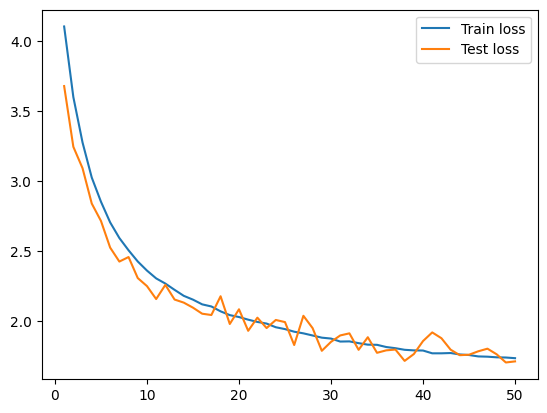

In [ ]:
plot_curves(epochs=epochs, metric="loss", metric_arr1=train_losses, metric_arr2=test_losses)

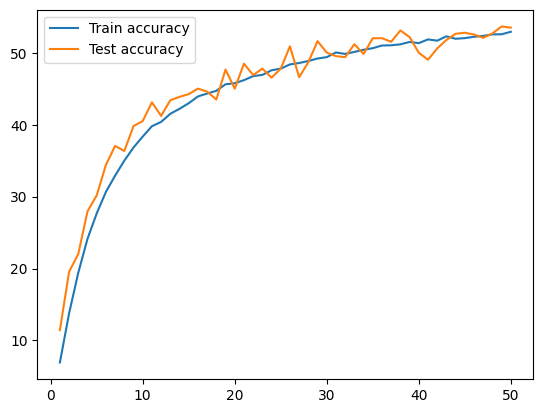

In [ ]:
plot_curves(epochs=epochs, metric="accuracy", metric_arr1=train_accs, metric_arr2=test_accs, to_cpu=False)

In [ ]:
96*2

In [ ]:
class Cifar100v3(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super(Cifar100v3, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fire2 = FireModule(64, 8, 32, 32)
    self.fire3 = FireModule(64, 8, 48, 48)

    self.proj2to3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=1, stride=1, padding=0)

    self.fire4 = nn.Sequential(
        FireModule(96, 16, 48, 48),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fire5 = FireModule(96, 16, 64, 64)

    self.proj4to5 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=1, stride=1, padding=0)


    self.fire6 = nn.Sequential(
        FireModule(128, 32, 128, 128),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fire7 = FireModule(256, 32, 128, 128)

    self.proj6to7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)

    self.fire8 = FireModule(256, 32, 256, 256)

    self.proj8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1)

    self.conv8 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU()
    )

    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.3),
        nn.Linear(in_features=512, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    identity = x

    x = self.fire2(x)
    x = x + identity

    identity = x
    identity = self.proj2to3(identity)
    x = self.fire3(x)
    x = x + identity

    x = self.fire4(x)

    identity = x
    identity = self.proj4to5(identity)
    x = self.fire5(x)
    x = x + identity

    x = self.fire6(x)

    identity = x
    identity = self.proj6to7(identity)
    x = self.fire7(x)
    x = x + identity


    x = self.proj8(x)
    x = self.conv8(x)

    x = self.global_avg_pool(x)
    x = self.classifier(x)

    return x

In [ ]:
model_2 = Cifar100v3(input_shape=3, output_shape=len(cifar100_train.classes))
model_2

Cifar100v3(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fire2): FireModule(
    (squeeze): Sequential(
      (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (expand1x1): Sequential(
      (0): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (expand3x3): Sequential(
      (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (fire3): FireModule(
    (squeeze): Sequenti

In [ ]:
summary(model=model_2, input_size=(32, 3 , 32, 32), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
Cifar100v3 (Cifar100v3)                       [32, 3, 32, 32]      [32, 100]            91,744               True
├─Sequential (conv1)                          [32, 3, 32, 32]      [32, 64, 16, 16]     --                   True
│    └─Conv2d (0)                             [32, 3, 32, 32]      [32, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                        [32, 64, 32, 32]     [32, 64, 32, 32]     128                  True
│    └─ReLU (2)                               [32, 64, 32, 32]     [32, 64, 32, 32]     --                   --
│    └─MaxPool2d (3)                          [32, 64, 32, 32]     [32, 64, 16, 16]     --                   --
├─FireModule (fire2)                          [32, 64, 16, 16]     [32, 64, 16, 16]     --                   True
│    └─Sequential (squeeze)                   [32, 64, 16, 16]     [32, 8, 16, 16]     

In [ ]:
loss2 = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_2 = torch.optim.AdamW(params=model_2.parameters(), lr=0.01)

In [ ]:
epochs = 50

train_losses, test_losses = [], []
train_accs, test_accs = [], []

start_train_time_model_2 = time.time()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---")

  train_loss, train_acc = model_train(model=model_2,
                                      loss_fn=loss2,
                                      optimizer_fn=optimizer_2,
                                      dataloader=train100_dataloader,
                                      device=device,
                                      epochs=epochs,
                                      accuracy_fn=accuracy_fn)

  test_loss, test_acc = model_test(model=model_2,
                                   loss_fn=loss2,
                                   dataloader=test100_dataloader,
                                   device=device,
                                   accuracy_fn=accuracy_fn)

  train_losses.append(train_loss)
  test_losses.append(test_loss)

  train_accs.append(train_acc)
  test_accs.append(test_acc)
stop_train_time_model_2 = time.time()

model_2_train_time = print_train_time(start=start_train_time_model_2,
                                      end=stop_train_time_model_2,
                                      model=model_2,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---
Train loss:  4.35544 | Train acc:  4.13%
Test loss:  4.14915 | Test acc:  7.42%
Epoch: 1
---
Train loss:  3.99788 | Train acc:  10.34%
Test loss:  3.85450 | Test acc:  13.64%
Epoch: 2
---
Train loss:  3.74434 | Train acc:  15.21%
Test loss:  3.48786 | Test acc:  19.95%
Epoch: 3
---
Train loss:  3.51597 | Train acc:  20.74%
Test loss:  3.41219 | Test acc:  23.33%
Epoch: 4
---
Train loss:  3.37646 | Train acc:  24.22%
Test loss:  3.18598 | Test acc:  28.87%
Epoch: 5
---
Train loss:  3.25373 | Train acc:  27.00%
Test loss:  3.21152 | Test acc:  28.70%
Epoch: 6
---
Train loss:  3.15262 | Train acc:  29.79%
Test loss:  3.15527 | Test acc:  31.12%
Epoch: 7
---
Train loss:  3.07873 | Train acc:  31.68%
Test loss:  2.91180 | Test acc:  35.83%
Epoch: 8
---
Train loss:  3.00861 | Train acc:  33.45%
Test loss:  2.85728 | Test acc:  38.08%
Epoch: 9
---
Train loss:  2.95148 | Train acc:  34.88%
Test loss:  2.88562 | Test acc:  37.54%
Epoch: 10
---
Train loss:  2.90455 | Train acc:  36.

In [ ]:
torch.save(model_2.state_dict(), '/kaggle/working/my_model_2.pth')

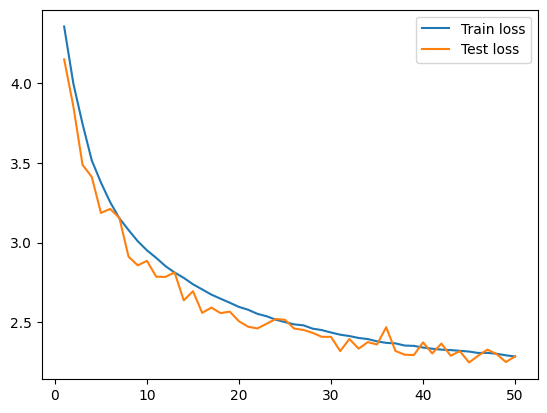

In [ ]:
plot_curves(epochs=epochs, metric="loss", metric_arr1=train_losses, metric_arr2=test_losses)

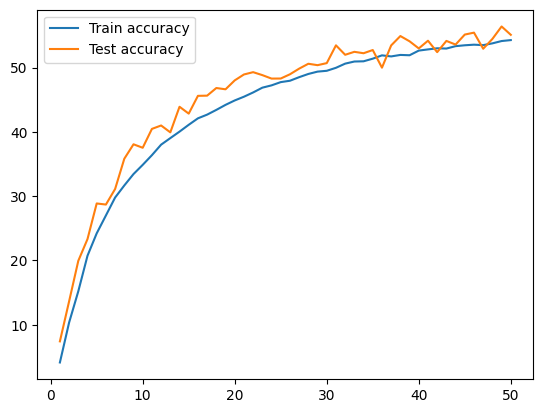

In [ ]:
plot_curves(epochs=epochs, metric="accuracy", metric_arr1=train_accs, metric_arr2=test_accs, to_cpu=False)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super(ResidualBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=channels)
        )

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv(x)
        out += x
        return self.relu(out)

In [ ]:
class Cifar100v4(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super(Cifar100v4, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.stage1 = nn.Sequential(
            ResidualBlock(channels=96)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.stage2 = nn.Sequential(
            ResidualBlock(channels=256)
        )


        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2)
        )

        # self.stage3 = nn.Sequential(
        #     ResidualBlock(channels=384),
        #     nn.Dropout(0.5)
        # )

        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(in_channels=384, out_channels=512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(num_features=512),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(num_features=512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        # )

        self.adp_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512*16, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.stage1(x)

        x = self.conv2(x)
        x = self.stage2(x)

        x = self.conv3(x)
        # x = self.stage3(x)

        # x = self.conv4(x)

        # x = self.adp_pool(x)

        x = self.classifier(x)
        return x


In [ ]:
model_3 = Cifar100v4(input_shape=3, output_shape=len(cifar100_train.classes))
# model_3 = nn.DataParallel(model_3, device_ids=[0, 1])
model_3

Cifar100v4(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (conv2): Sequential(
    (0): Conv2d(96, 128, kernel_size=(3, 3), strid

In [ ]:
summary(model=model_3, input_size=(32, 3 , 32, 32), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Cifar100v4 (Cifar100v4)                  [32, 3, 32, 32]      [32, 100]            --                   True
├─Sequential (conv1)                     [32, 3, 32, 32]      [32, 96, 16, 16]     --                   True
│    └─Conv2d (0)                        [32, 3, 32, 32]      [32, 96, 32, 32]     2,688                True
│    └─BatchNorm2d (1)                   [32, 96, 32, 32]     [32, 96, 32, 32]     192                  True
│    └─ReLU (2)                          [32, 96, 32, 32]     [32, 96, 32, 32]     --                   --
│    └─Conv2d (3)                        [32, 96, 32, 32]     [32, 96, 32, 32]     83,040               True
│    └─BatchNorm2d (4)                   [32, 96, 32, 32]     [32, 96, 32, 32]     192                  True
│    └─ReLU (5)                          [32, 96, 32, 32]     [32, 96, 32, 32]     --                   --
│    └─MaxPool2d (

In [ ]:
loss3 = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer3 = torch.optim.AdamW(params=model_3.parameters(),
                            lr=0.01)

In [ ]:
epochs = 50

train_losses, test_losses = [], []
train_accs, test_accs = [], []

start_train_time_model_3 = time.time()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---")

  train_loss, train_acc = model_train(model=model_3,
                                      loss_fn=loss3,
                                      optimizer_fn=optimizer3,
                                      dataloader=train100_dataloader,
                                      device=device,
                                      epochs=epochs,
                                      accuracy_fn=accuracy_fn)

  test_loss, test_acc = model_test(model=model_3,
                                   loss_fn=loss3,
                                   dataloader=test100_dataloader,
                                   device=device,
                                   accuracy_fn=accuracy_fn)

  train_losses.append(train_loss)
  test_losses.append(test_loss)

  train_accs.append(train_acc)
  test_accs.append(test_acc)
stop_train_time_model_3 = time.time()

model_3_train_time = print_train_time(start=start_train_time_model_3,
                                      end=stop_train_time_model_3,
                                      model=model_3,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---
Train loss:  4.74491 | Train acc:  3.06%
Test loss:  4.13053 | Test acc:  8.01%
Epoch: 1
---
Train loss:  4.11172 | Train acc:  8.64%
Test loss:  3.74508 | Test acc:  16.75%
Epoch: 2
---
Train loss:  3.83181 | Train acc:  14.56%
Test loss:  3.45947 | Test acc:  22.93%
Epoch: 3
---
Train loss:  3.59304 | Train acc:  19.87%
Test loss:  3.24439 | Test acc:  28.18%
Epoch: 4
---
Train loss:  3.35403 | Train acc:  25.19%
Test loss:  2.99223 | Test acc:  35.61%
Epoch: 5
---
Train loss:  3.18645 | Train acc:  29.25%
Test loss:  2.87927 | Test acc:  37.79%
Epoch: 6
---
Train loss:  3.06256 | Train acc:  32.94%
Test loss:  2.88102 | Test acc:  37.50%
Epoch: 7
---
Train loss:  2.97251 | Train acc:  34.97%
Test loss:  2.67210 | Test acc:  43.64%
Epoch: 8
---
Train loss:  2.89912 | Train acc:  37.03%
Test loss:  2.64540 | Test acc:  44.37%
Epoch: 9
---
Train loss:  2.83698 | Train acc:  38.76%
Test loss:  2.57281 | Test acc:  46.39%
Epoch: 10
---
Train loss:  2.79236 | Train acc:  39.9

KeyboardInterrupt: 

In [ ]:
torch.save(model_3.state_dict(), '/kaggle/working/my_model_3.pth')

In [ ]:
plot_curves(epochs=epochs, metric="loss", metric_arr1=train_losses, metric_arr2=test_losses)

In [ ]:
plot_curves(epochs=epochs, metric="accuracy", metric_arr1=train_accs, metric_arr2=test_accs, to_cpu=False)

In [ ]:
class Cifar100v5(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super(Cifar100v5, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),

            FireModule(96, 12, 48, 48),

            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),

            FireModule(128, 12, 64, 64),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),

            FireModule(256, 28, 256, 256),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.adp_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)

        x = self.conv2(x)

        x = self.conv3(x)

        x = self.adp_pool(x)

        x = self.classifier(x)
        return x


In [ ]:
model_4 = Cifar100v5(input_shape=3, output_shape=len(cifar100_train.classes))
model_4

Cifar100v5(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): FireModule(
      (squeeze): Sequential(
        (0): Conv2d(96, 12, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (expand1x1): Sequential(
        (0): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (expand3x3): Sequential(
        (0): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (4): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128

In [ ]:
summary(model=model_4, input_size=(32, 3 , 32, 32), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Cifar100v5 (Cifar100v5)                  [32, 3, 32, 32]      [32, 100]            --                   True
├─Sequential (conv1)                     [32, 3, 32, 32]      [32, 128, 16, 16]    --                   True
│    └─Conv2d (0)                        [32, 3, 32, 32]      [32, 96, 32, 32]     2,688                True
│    └─BatchNorm2d (1)                   [32, 96, 32, 32]     [32, 96, 32, 32]     192                  True
│    └─ReLU (2)                          [32, 96, 32, 32]     [32, 96, 32, 32]     --                   --
│    └─FireModule (3)                    [32, 96, 32, 32]     [32, 96, 32, 32]     --                   True
│    │    └─Sequential (squeeze)         [32, 96, 32, 32]     [32, 12, 32, 32]     1,188                True
│    │    └─Sequential (expand1x1)       [32, 12, 32, 32]     [32, 48, 32, 32]     720                  True
│    │    └─Sequ

In [ ]:
loss4 = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer4 = torch.optim.AdamW(params=model_4.parameters(),
                            lr=0.01)

In [ ]:
epochs = 50

train_losses, test_losses = [], []
train_accs, test_accs = [], []

start_train_time_model_4 = time.time()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---")

  train_loss, train_acc = model_train(model=model_4,
                                      loss_fn=loss4,
                                      optimizer_fn=optimizer4,
                                      dataloader=train100_dataloader,
                                      device=device,
                                      epochs=epochs,
                                      accuracy_fn=accuracy_fn)

  test_loss, test_acc = model_test(model=model_4,
                                   loss_fn=loss4,
                                   dataloader=test100_dataloader,
                                   device=device,
                                   accuracy_fn=accuracy_fn)

  train_losses.append(train_loss)
  test_losses.append(test_loss)

  train_accs.append(train_acc)
  test_accs.append(test_acc)
stop_train_time_model_4 = time.time()

model_4_train_time = print_train_time(start=start_train_time_model_4,
                                      end=stop_train_time_model_4,
                                      model=model_4,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---
Train loss:  4.39816 | Train acc:  3.83%
Test loss:  4.19304 | Test acc:  6.05%
Epoch: 1
---
Train loss:  4.05490 | Train acc:  8.88%
Test loss:  3.92667 | Test acc:  11.44%
Epoch: 2
---
Train loss:  3.74682 | Train acc:  15.45%
Test loss:  3.55912 | Test acc:  19.67%
Epoch: 3
---
Train loss:  3.38677 | Train acc:  23.53%
Test loss:  3.43947 | Test acc:  22.36%
Epoch: 4
---
Train loss:  3.13153 | Train acc:  30.01%
Test loss:  3.05101 | Test acc:  32.11%
Epoch: 5
---
Train loss:  2.94776 | Train acc:  35.00%
Test loss:  2.78215 | Test acc:  39.95%
Epoch: 6
---
Train loss:  2.80953 | Train acc:  38.92%
Test loss:  3.14969 | Test acc:  31.18%
Epoch: 7
---
Train loss:  2.69960 | Train acc:  42.04%
Test loss:  2.68292 | Test acc:  42.30%
Epoch: 8
---
Train loss:  2.61482 | Train acc:  44.57%
Test loss:  2.61487 | Test acc:  43.99%
Epoch: 9
---
Train loss:  2.54190 | Train acc:  46.78%
Test loss:  2.42096 | Test acc:  50.15%
Epoch: 10
---
Train loss:  2.47734 | Train acc:  48.8

In [ ]:
torch.save(model_4.state_dict(), '/kaggle/working/my_model_4.pth')

In [ ]:
plot_curves(epochs=epochs, metric="loss", metric_arr1=train_losses, metric_arr2=test_losses)

In [ ]:
plot_curves(epochs=epochs, metric="accuracy", metric_arr1=train_accs, metric_arr2=test_accs, to_cpu=False)